### VAERS Data Analysis

### SQL queries with Aggregrations 

#### Investigate number of adverse events, deaths and recoveries related to vaccination over time using Adverse_Event table. 

In [210]:
%%bigquery
select ONSET_DATE as Date, COUNT(VAERS_ID) as Cases, COUNTIF(DIED = true) as Deaths, COUNTIF(RECOVD = true) as Recovered
from vaers_modeled.Adverse_Event_Beam_DF
where ONSET_DATE is not null 
group by ONSET_DATE
order by ONSET_DATE desc
limit 10

,Date,Cases,Deaths,Recovered
0,2019-12-14,2,0,0
1,2019-12-13,4,0,0
2,2019-12-12,11,0,4
3,2019-12-11,12,0,1
4,2019-12-10,15,0,7
5,2019-12-09,8,0,4
6,2019-12-08,3,0,1
7,2019-12-07,12,0,6
8,2019-12-06,10,0,5
9,2019-12-05,14,0,4


#### Create database view from aggregrate query above (Date vs Cases, Deaths and Recovered) for Google Data Studio.

In [237]:
%%bigquery
create or replace view vaers_modeled.v_Cases_By_Date as
select ONSET_DATE as Date, COUNT(VAERS_ID) as Cases, COUNTIF(DIED = true) as Deaths, COUNTIF(RECOVD = true) as Recovered
from `studied-brand-266702.vaers_modeled.Adverse_Event_Beam_DF`
where ONSET_DATE is not null 
group by ONSET_DATE
order by ONSET_DATE desc

""


#### View total number of adverse events by state by joining Patient table with Adverse Event table. <br> Notice the highest number of cases happen in California.

In [15]:
%%bigquery
select STATE as State, COUNT(e.VAERS_ID) as Cases
from vaers_modeled.Patient p join vaers_modeled.Adverse_Event_Beam_DF e on p.VAERS_ID = e.VAERS_ID
where STATE is not null
group by STATE
order by Cases desc
limit 10

,State,Cases
0,CA,3002
1,TX,1967
2,FL,1821
3,NY,1706
4,PA,1583
5,MI,1343
6,OH,1175
7,NC,1071
8,IL,956
9,MA,917


#### Create database view from aggregrate query above (Cases by State) for Google Data Studio.

In [188]:
%%bigquery
create or replace view vaers_modeled.v_Cases_By_State as
select STATE as State, COUNT(e.VAERS_ID) as Cases
from `studied-brand-266702.vaers_modeled.Patient` p join `studied-brand-266702.vaers_modeled.Adverse_Event_Beam_DF` e on p.VAERS_ID = e.VAERS_ID
where STATE != "None" 
group by STATE
order by Cases desc

""


#### Join Vaccine table, Vaccination table, Adverse_Event table and Patient table to view number of deaths reported for each vaccine as well as the patient's maximum and minimum age. Filtered to more than 5 deaths and valid patient age. (Age = 0 refer to infants) <br> Influenza and Pnuemo vaccines are associated with highest number of deaths. These occur to individuals of all ages given the range of patient ages.

In [236]:
%%bigquery
select v.VAX_NAME as Vaccine_Name, COUNT(e.DIED) as Deaths, MAX(AGE_YRS) as Max_Patient_Age, MIN(AGE_YRS) as Min_Patient_Age 
from (vaers_modeled.Vaccine v join vaers_modeled.Vaccination_Beam_DF vax on v.VAX_ID = vax.VAX_ID)
    join vaers_modeled.Adverse_Event_Beam_DF e on vax.VAERS_ID = e.VAERS_ID
    join vaers_modeled.Patient p on vax.VAERS_ID = p.VAERS_ID
where DIED is true 
group by v.VAX_NAME
having Deaths > 5 and Max_Patient_Age is not null
order by Deaths desc

,Vaccine_Name,Deaths,Max_Patient_Age,Min_Patient_Age
0,INFLUENZA (SEASONAL) (NO BRAND NAME),25,84,2
1,PNEUMO (PREVNAR13),24,87,0
2,HPV (GARDASIL),19,21,21
3,ROTAVIRUS (ROTATEQ),18,1,0
4,ZOSTER (SHINGRIX),17,94,55
5,ZOSTER LIVE (ZOSTAVAX),16,85,59
6,VACCINE NOT SPECIFIED (NO BRAND NAME),12,66,0
7,DTAP + IPV + HIB (PENTACEL),12,0,0
8,DTAP + HEPB + IPV (PEDIARIX),11,1,0
9,HEP B (ENGERIX-B),8,50,0


#### Join Adverse_Event table with Patient table and calculate average age of patients who died by state. <br> Vaccine-related deaths in North Carolina (NC) occur to infants (Age < 1)  

In [16]:
%%bigquery
select STATE as State, AVG(AGE_YRS) as Average_Age, COUNT(DIED) as Deaths
from vaers_modeled.Patient p join vaers_modeled.Adverse_Event_Beam_DF e on p.VAERS_ID = e.VAERS_ID
where STATE is not null and DIED = true
group by STATE
order by Deaths desc
limit 10

,State,Average_Age,Deaths
0,OH,45.000000,8
1,NY,63.800000,6
2,CA,18.333333,4
3,SC,39.250000,4
4,PA,42.500000,4
5,GA,21.000000,4
6,AR,25.666667,3
7,NC,0.666667,3
8,TN,43.500000,3
9,LA,44.500000,3


#### Investigate number of deaths associated with the manufacturer of the vaccine connected to the adverse event. <br> Two manufacturers in particular have the highest associated number of deaths.

In [212]:
%%bigquery
select m.VAX_MANU as Vaccine_Manufacturer, COUNT(e.DIED) as Deaths
from (vaers_modeled.Manufacturer m join vaers_modeled.Vaccination_Beam_DF v on v.MANU_ID = m.MANU_ID)
    join vaers_modeled.Adverse_Event_Beam_DF e on v.VAERS_ID = e.VAERS_ID
where m.VAX_MANU != "UNKNOWN MANUFACTURER" and DIED = true
group by m.VAX_MANU
order by Deaths desc

,Vaccine_Manufacturer,Deaths
0,MERCK & CO. INC.,82
1,GLAXOSMITHKLINE BIOLOGICALS,61
2,PFIZER\WYETH,25
3,SANOFI PASTEUR,22
4,"SEQIRUS, INC.",5
5,NOVARTIS VACCINES AND DIAGNOSTICS,4
6,CSL LIMITED,1
7,PROTEIN SCIENCES CORPORATION,1
8,AVENTIS PASTEUR,1
9,"MEDIMMUNE VACCINES, INC.",1


#### Join Vaccine table and Manufacturer table through Vaccination table to figure out which vaccine is produced by more than one manufacturer. <br> Only four vaccines are produced by more than one manufacturer.

In [238]:
%%bigquery
select VAX_NAME as Vaccine_Name, COUNT(DISTINCT VAX_MANU) as Num_Manufacturers
from (vaers_modeled.Manufacturer m join vaers_modeled.Vaccination_Beam_DF vax on vax.MANU_ID = m.MANU_ID)
    join vaers_modeled.Vaccine v on v.VAX_ID = vax.VAX_ID
where m.VAX_MANU != "UNKNOWN MANUFACTURER"
group by VAX_NAME
having Num_Manufacturers > 1
order by VAX_NAME

,Vaccine_Name,Num_Manufacturers
0,HEP A (HAVRIX),2
1,INFLUENZA (SEASONAL) (FLUZONE),2
2,TD ADSORBED (NO BRAND NAME),2
3,TYPHOID VI POLYSACCHARIDE (TYPHIM VI),2


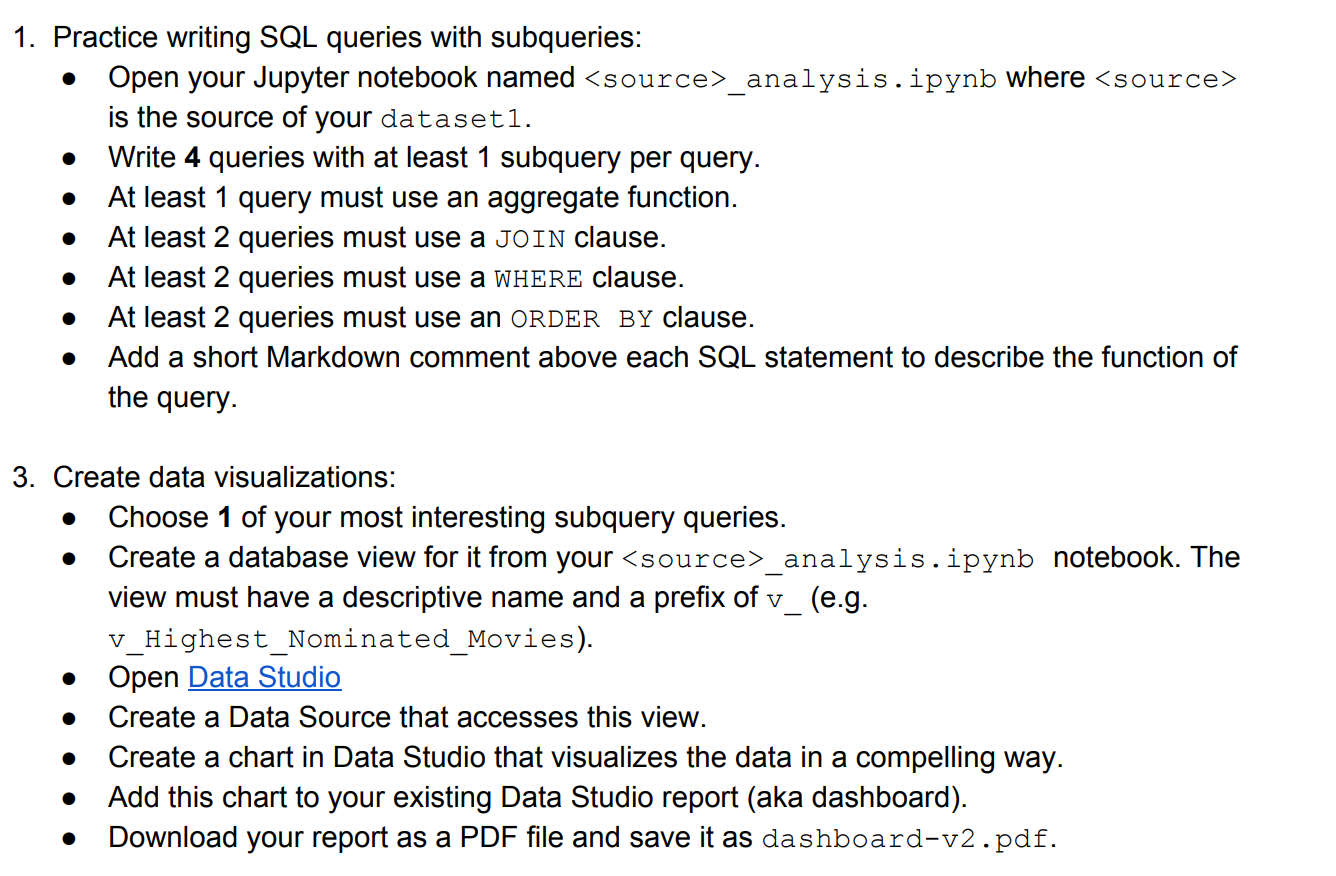

### SQL queries with Subqueries 

#### View states with deaths greater than *average* number of deaths per state, by joining Patient table with Adverse Event table, ordered by total deaths. <br> Notice the highest number of deaths happen in Ohio.

In [44]:
%%bigquery
# List states with deaths greater than average number of deaths per state
select STATE as State, COUNTIF(DIED = true) as Deaths
from vaers_modeled.Patient p join vaers_modeled.Adverse_Event_Beam_DF e on p.VAERS_ID = e.VAERS_ID
where STATE is not null
group by STATE
having Deaths >
# Compute average number of deaths per state
(select AVG(Deaths) as Average_deaths
from
# Compute number of deaths for all states
(select STATE, COUNTIF(DIED = true) as Deaths
from vaers_modeled.Patient p join vaers_modeled.Adverse_Event_Beam_DF e on p.VAERS_ID = e.VAERS_ID
where STATE is not null
group by STATE))
order by Deaths desc
limit 10

,State,Deaths
0,OH,8
1,NY,6
2,GA,4
3,CA,4
4,SC,4
5,PA,4
6,TX,3
7,LA,3
8,NC,3
9,TN,3


#### List patient ages with highest number of deaths, by joining Patient table with Adverse Event table, ordered by total deaths. <br> Notice that most deaths occur to infants and toddlers.

In [69]:
%%bigquery
# List patient ages with highest number of deaths 
select AGE_YRS as Age, COUNT(AGE_YRS) as Deaths
from
# Retrieve patient ages when they died and that are not null 
(select AGE_YRS 
from vaers_modeled.Patient p join vaers_modeled.Adverse_Event_Beam_DF e on p.VAERS_ID = e.VAERS_ID
where DIED = true and AGE_YRS is not null)
group by AGE_YRS
order by Deaths desc
limit 10

,Age,Deaths
0,0,27
1,1,12
2,70,3
3,73,3
4,2,2
5,43,2
6,66,2
7,75,2
8,55,2
9,84,2


#### Create database view from aggregrate query above (Deaths by Age) for Google Data Studio.

In [67]:
%%bigquery
create or replace view vaers_modeled.v_Deaths_By_Age as
select AGE_YRS as Age, COUNT(AGE_YRS) as Deaths
from
(select AGE_YRS 
from `studied-brand-266702.vaers_modeled.Patient` p join `studied-brand-266702.vaers_modeled.Adverse_Event_Beam_DF` e on p.VAERS_ID = e.VAERS_ID
where DIED = true and AGE_YRS is not null)
group by AGE_YRS
order by Deaths desc

""


#### 3rd

#### 4th